In [2]:
import pickle
from scipy import sparse
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import spektral
import os
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import keras_tuner as kt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd
import openpyxl

In [102]:
#counter current
cocurrent = pd.read_excel(r"C:\Users\buing\Documents\CBE 424\heat exchanger\cocurrent.xlsx")
counter = pd.read_excel(r"C:\Users\buing\Documents\CBE 424\heat exchanger\counterflow.xlsx")
both_flow_prop = pd.read_excel(r"C:\Users\buing\Documents\CBE 424\heat exchanger\bothflow_error_prop.xlsx")

In [103]:
print(both_flow_prop["Q_prop"])

0     0.109547
1     0.067958
2     0.062573
3     0.062490
4     0.086729
5     0.092155
6     0.229198
7     0.088565
8     0.077815
9     0.060673
10    0.063799
11    0.069728
12    0.216868
13    0.088631
14    0.083019
15    0.067718
16    0.068176
17    0.074153
18    0.381062
19    0.141217
20    0.113387
21    0.092896
22    0.090408
23    0.082007
24    0.446003
25    0.168910
26    0.116484
27    0.093429
28    0.092082
29    0.094556
30    0.988264
31    0.291472
32    0.174278
33    0.139715
34    0.118682
35    0.108167
36    0.589341
37    0.209557
38    0.145428
39    0.123638
40    0.107609
41    0.101808
42    0.437001
43    0.194983
44    0.155432
45    0.118964
46    0.108189
47    0.101717
48    0.355865
49    0.152599
50    0.100223
51    0.091126
52    0.097091
53    0.103962
54    0.368043
55    0.135613
56    0.100606
57    0.092989
58    0.099694
59    0.104544
60    0.268789
61    0.137421
62    0.074190
63    0.072180
64    0.080869
65    0.099458
66    0.09

In [104]:
dat_co = pd.DataFrame(cocurrent)
dat_cu = pd.DataFrame(counter)

In [105]:
#co-current

hot_rate_co = dat_co["Ms (kg/s)"]
cold_rate_co = dat_co["Mi1 (kg/s)"]
wc_co = cold_rate_co
wh_co = hot_rate_co
Th_in_co = dat_co["Th_in"]
Th_out_co = dat_co["Th_out"]
Tc_in_co = dat_co["Tc_in"]
Tc_out_co = dat_co["Tc_out"]

#counter-current

hot_rate_cu = dat_cu["Ms (kg/s)"]
cold_rate_cu = dat_cu["Mi1 (kg/s)"]
wc_cu = cold_rate_cu
wh_cu = hot_rate_cu
Th_in_cu = dat_cu["Th_in"]
Th_out_cu = dat_cu["Th_out"]
Tc_in_cu = dat_cu["Tc_in"]
Tc_out_cu = dat_cu["Tc_out"]

In [122]:
dT_cu = ((Th_in_cu - Th_out_cu) - (Th_out_cu - Tc_in_cu))/np.log(((Th_in_cu - Th_out_cu)/(Th_out_cu - Tc_in_cu)))
dT_co = ((Th_in_co - Tc_in_co) - (Th_out_co - Tc_out_co))/np.log(((Th_in_co - Tc_in_co)/(Th_out_co - Tc_out_co)))

#counter
Cp = 4.182 #kJ/kgC
Qc_co = wc_co*Cp*(Tc_out_co- Tc_in_co)      #Qc = wc*Cp_c*(Tc_out - Tc_in)
Qh_co = wh_co*Cp*(Th_out_co- Th_in_co)   #Qh = wh*Cp_h*(Th_out- Th_in)
Qc_cu = wc_cu*Cp*(Tc_out_cu- Tc_in_cu)
Qh_cu = wh_cu*Cp*(Th_out_cu- Th_in_cu)
Q_co = ((Qc_co) - (Qh_co))/(0.5*(abs(Qc_co) + abs(Qh_co)))
Q_cu = ((Qc_cu) + (Qh_cu))/(0.5*(abs(Qc_cu) + abs(Qh_cu)))
Q = [Q_co,Q_cu]
pd.set_option('display.max_rows', None)
print(pd.concat(Q).to_numpy())
Q_np = pd.concat(Q).to_numpy()
pd.set_option('display.max_rows', None)

print(Qc_cu[0],Qh_cu[0],wc_cu[0])

[-0.01131765  0.02026412  0.01594788  0.04803727  0.01190595 -0.03187122
 -0.02529077 -0.00904294  0.01897447  0.02219749  0.01834759  0.02347024
  0.00414913  0.02897754  0.01805681  0.01680575  0.0079539   0.02422759
 -0.07536263 -0.01913609  0.02451929  0.01740731  0.01264068  0.02252983
 -0.10332488  0.01899391  0.03619728  0.01836668  0.00926091  0.00474374
 -0.05214651  0.0035442  -0.04308004  0.0028985   0.02538601  0.01472885
 -0.07873827 -0.06052058 -0.02657628 -0.02808914 -0.01849898 -0.00297006
  0.00869635  0.00317037 -0.02450456  0.03635012  0.03819209  0.03017658
  0.0733977  -0.20066854  0.03377087  0.05904478  0.06312971  0.0350179
 -0.00551072  0.0144157  -0.01029399  0.03967445 -0.05448233  0.07107502
  0.07550404  0.03078892  0.05017788  0.07371918  0.01608365  0.00136853
 -0.04159535  0.00420628 -0.03265687  0.0022071   0.01484985  0.02740767]
3.5025553615960097 -3.789642882793022 0.03740648379052369


In [107]:
#error propagation
dQ_prop = both_flow_prop["Q_prop"]
print(dQ_prop,Q_np)

0     0.109547
1     0.067958
2     0.062573
3     0.062490
4     0.086729
5     0.092155
6     0.229198
7     0.088565
8     0.077815
9     0.060673
10    0.063799
11    0.069728
12    0.216868
13    0.088631
14    0.083019
15    0.067718
16    0.068176
17    0.074153
18    0.381062
19    0.141217
20    0.113387
21    0.092896
22    0.090408
23    0.082007
24    0.446003
25    0.168910
26    0.116484
27    0.093429
28    0.092082
29    0.094556
30    0.988264
31    0.291472
32    0.174278
33    0.139715
34    0.118682
35    0.108167
36    0.589341
37    0.209557
38    0.145428
39    0.123638
40    0.107609
41    0.101808
42    0.437001
43    0.194983
44    0.155432
45    0.118964
46    0.108189
47    0.101717
48    0.355865
49    0.152599
50    0.100223
51    0.091126
52    0.097091
53    0.103962
54    0.368043
55    0.135613
56    0.100606
57    0.092989
58    0.099694
59    0.104544
60    0.268789
61    0.137421
62    0.074190
63    0.072180
64    0.080869
65    0.099458
66    0.09

In [108]:
A = 31*np.pi*7.875*0.21/(39.37*39.37)
U = Q/(A*dT_co)
Gi = wc/(np.pi*31*np.power((0.21/39.37),2)/4)
Gs = wh/(np.pi*31*np.power((0.25/39.37),2)/4)
#dT_co = ((Th_in - Tc_in) - (Th_out - Tc_out))/np.log(((Th_in - Tc_in)/(Th_out - Tc_out)))
flip_U = 1/U
print(U,Gi,Gs)

ValueError: Length of values (2) does not match length of index (36)

In [109]:
error_dat = dat[dat["mi2 (kg)"].notna()]
#print(error_dat)
Ms_err = error_dat["Ms (kg/s)"].to_numpy()
M1 = error_dat["Mi1 (kg/s)"].to_numpy()
M2 = error_dat["mi2 (kg)"].to_numpy()/error_dat["ti2 (s)"].to_numpy()
#print(M1,M2)
Avg_Mi = (M1+M2)/2
std_Mi = np.std([M1, M2],axis = 0)
print(Avg_Mi, std_Mi)

[0.61111286 0.61111286 0.01620378 0.08033048 0.01620378 0.51014855
 0.78762922 0.45319786 0.78762922] [0.00044092 0.00044092 0.00079622 0.00030402 0.00079622 0.00277392
 0.00262922 0.00215928 0.00262922]


In [110]:
print(error_dat)
Th_in_err = error_dat["Th_in"]
Th_out_err = error_dat["Th_out"]
Tc_in_err = error_dat["Tc_in"]
Tc_out_err = error_dat["Tc_out"]
Ms_err = error_dat["Ms (kg/s)"]
Gi_err = M1/(np.pi*31*np.power((0.21/39.37),2)/4)
Cp = 4.182
dT_counter_err = ((Th_in_err - Th_out_err) - (Th_out_err - Tc_in_err))/np.log(((Th_in_err - Th_out_err)/(Th_out_err - Tc_in_err)))
Qc_err1 = M1*Cp*(Tc_out_err - Tc_in_err)
Qc_err2 = M2*Cp*(Tc_out_err - Tc_in_err)
Qc_avg = (Qc_err1+Qc_err2)/2
Qc_std = np.std([Qc_err1, Qc_err2],axis = 0)
Qh = Ms_err*Cp*(Th_out_err - Th_in_err)
A = 31*np.pi*7.875*0.21/(39.37*39.37)
Q_err1 = (abs(Qc_err1) + abs(Qh))/2
Q_err2 = (abs(Qc_err2) + abs(Qh))/2
U_err1 = Q_err1/(A*dT_counter_err)
U_err2 = Q_err2/(A*dT_counter_err)
U_avg = (U_err1+U_err2)/2
U_std = np.std([U_err1, U_err2],axis = 0)
print(U_avg,U_std)

      ms     ts  Ms (kg/s)  mi1 (kg)  ti1 (s)  Mi1 (kg/s)  mi2 (kg)  ti2 (s)  \
5   8.09  10.15   0.797044      6.14    10.04    0.611554      6.18    10.12   
11  7.38  10.15   0.727094      6.14    10.04    0.611554      6.18    10.12   
18  6.11  10.18   0.600196      0.34    20.00    0.017000      0.31    20.12   
19  6.11  10.18   0.600196      1.22    15.13    0.080635      1.21    15.12   
24  5.66  10.50   0.539048      0.34    20.00    0.017000      0.31    20.12   
28  5.66  10.50   0.539048      5.16    10.17    0.507375      5.16    10.06   
29  5.66  10.50   0.539048      7.95    10.06    0.790258      7.85    10.00   
33  6.18  15.15   0.407921      4.56    10.11    0.451039      4.59    10.08   
35  6.18  15.15   0.407921      7.95    10.06    0.790258      7.85    10.00   

    Th_in  Th_out  Tc_in  Tc_out  
5   60.88   55.41  22.53   15.17  
11  59.58   53.94  22.10   15.55  
18  56.05   55.20  47.79   15.43  
19  55.27   52.92  33.11   15.28  
24  59.69   58.65  52.21

In [111]:
def func(G,a,b,c,d,e):
    Gi,Gs = G
    return (a/np.power(Gi,b)) + c + (d/np.power(Gs,e))
    #Sieder_tate_LHS = h*D/k
    #Sieder_tate_RHS = 0.023 * (D*G/miu)^0.8 * (Cp*miu/k)^(1/3) * (miu_b/miu_o)^0.14

    #Kern_LHS = h_o*D_e/k
    #Kern_RHS = 0.36 * (D_e*G_s/miu)^0.55 * (Cp*miu/k)^(1/3) * (miu_b/miu_o)^0.14

    #param fitting
    #LHS = 1/U
    #RHS = a/(wc^b) + c + d/(wh^e)

    #hi_exp = 1/a*wc^b
    #h0_exp = (1/d)*(Ai/A0)*(wh^e)


In [112]:
guess = [1, 0.3, 0, 1,0.6]
a,b,c,d,e = guess
LHS = func((Gi,Gs),a,b,c,d,e)
param = curve_fit(func,(Gi,Gs),flip_U,guess,maxfev=20000)
LHS_fit = func((Gi,Gs),*param[0])
U_fit = 1/LHS_fit

print(param)

NameError: name 'Gi' is not defined

Text(0, 0.5, '$\\frac{(\\.Q_c + \\.Q_c)}{0.5(|\\.Q_c| + |\\.Q_c|)}$ ')

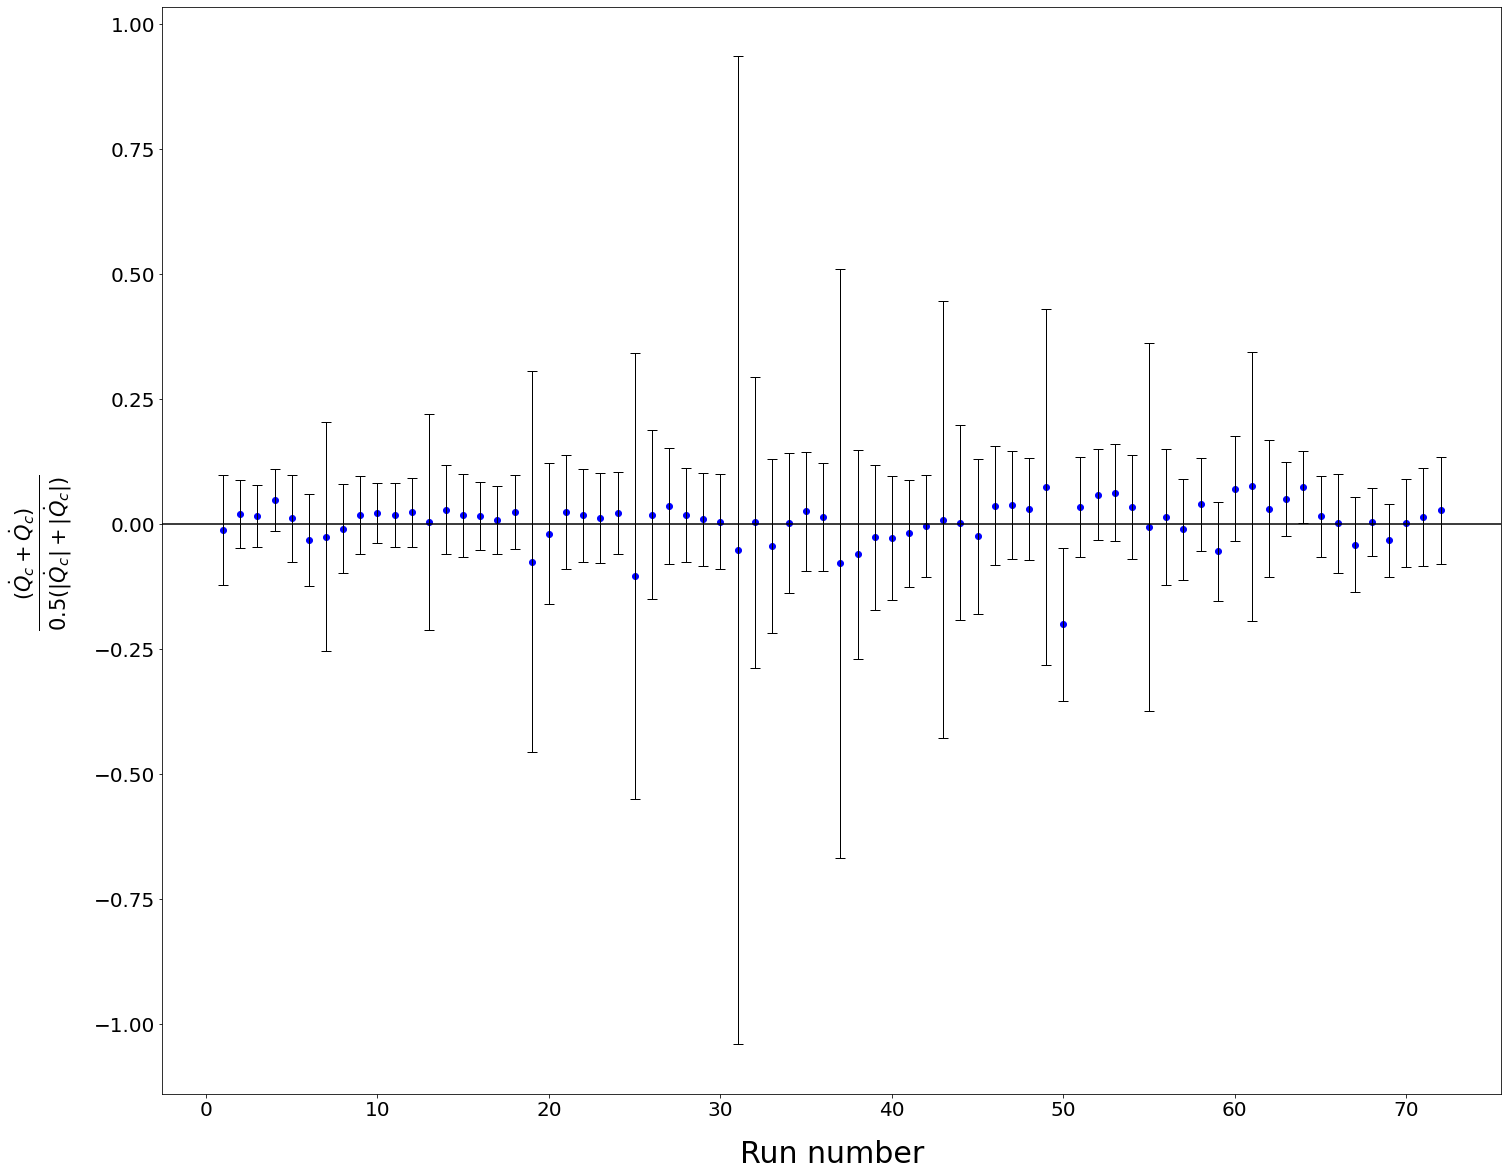

In [123]:
fig = figure(figsize = (24,20))
x_axis = np.linspace(1,72,72)
plt.plot(x_axis,Q_np,'bo')
plt.errorbar(x_axis,Q_np,yerr = [dQ_prop], fmt = 'none',ecolor = 'black',capsize = 5,elinewidth = 1)
plt.axhline(y=0, c="black")
plt.ylabel(r"$U^{Exp}$ $(\frac{kJ} {m^{2}s \cdot{K}})$", fontsize = 30,labelpad=20)
plt.xlabel(r"Run number",fontsize = 30,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel(r"$\frac{(\.Q_c + \.Q_c)}{0.5(|\.Q_c| + |\.Q_c|)}$ ",fontsize = 30,labelpad=20)

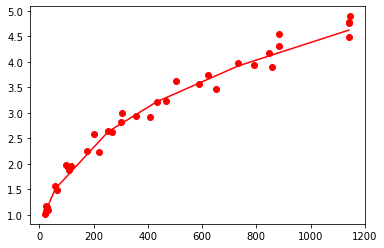

In [ ]:
# Mathtext demo
fig, ax = plt.subplots()
ax.plot(range(10))
ax.set_title(r'$\ddot{o}\acute{e}\grave{e}\hat{O}'
             r'\breve{i}\bar{A}\tilde{n}\vec{q}$', fontsize=20)

# Shorthand is also supported and curly braces are optional
ax.set_xlabel(r"""$\"o\ddot o \'e\`e\~n\.x\^y$""", fontsize=20)
ax.text(4, 0.5, r"$F=m\ddot{x}$")
fig.tight_layout()

In [46]:
Gi_spline_1 = np.sort(Gi1)
Gi_spline_2 = np.sort(Gi2)
Gi_spline_3 = np.sort(Gi3)
Gi_spline_4 = np.sort(Gi4)
Gi_spline_5 = np.sort(Gi5)
Gi_spline_6 = np.sort(Gi6)

#U_spline_1 = 1/func((Gi_spline_1,Gs1),*param[0])
#U_spline_2 = 1/func((Gi_spline_1,Gs2),*param[0])
#U_spline_3 = 1/func((Gi_spline_1,Gs3),*param[0])
#U_spline_4 = 1/func((Gi_spline_1,Gs4),*param[0])
#U_spline_5 = 1/func((Gi_spline_1,Gs5),*param[0])
#U_spline_6 = 1/func((Gi_spline_1,Gs6),*param[0])
#D_model = np.linspace(D_spline.min(), D_spline.max(), 500)
Gi_model = np.linspace(Gi.min(),Gi.max(),120)
Gi_model1 = np.linspace(Gi1.min(), Gi1.max(), 120)
Gi_model2 = np.linspace(Gi2.min(), Gi2.max(), 120)
Gi_model3 = np.linspace(Gi3.min(), Gi3.max(), 120)
Gi_model4 = np.linspace(Gi4.min(), Gi4.max(), 120)
Gi_model5 = np.linspace(Gi5.min(), Gi5.max(), 120)
Gi_model6 = np.linspace(Gi6.min(), Gi6.max(), 120)
#Gi1_spl = make_interp_spline(Gi_spline_1,U_spline_1)
#Gi2_spl = make_interp_spline(Gi_spline_2,U_spline_2)
#Gi3_spl = make_interp_spline(Gi_spline_3,U_spline_3)
#Gi4_spl = make_interp_spline(Gi_spline_4,U_spline_4)
#Gi5_spl = make_interp_spline(Gi_spline_5,U_spline_5)
#Gi6_spl = make_interp_spline(Gi_spline_6,U_spline_6)
Gs_model1 = np.repeat(Gs1,20)
Gs_model2 = np.repeat(Gs2,20)
Gs_model3 = np.repeat(Gs3,20)
Gs_model4 = np.repeat(Gs4,20)
Gs_model5 = np.repeat(Gs5,20)
Gs_model6 = np.repeat(Gs6,20)
U1_model =  1/func((Gi_model,Gs_model1),*param[0])
U2_model = 1/func((Gi_model,Gs_model2),*param[0])
U3_model = 1/func((Gi_model,Gs_model3),*param[0])
U4_model = 1/func((Gi_model,Gs_model4),*param[0])
U5_model = 1/func((Gi_model,Gs_model5),*param[0])
U6_model = 1/func((Gi_model,Gs_model6),*param[0])
label = np.unique(Gs)
l_width = 0.5
marksize = 4
fig = figure(figsize = (12,9))
plt.plot(Gi_model,U1_model,'b-',linewidth = l_width, label = str(int(label[0])))
#plt.annotate(int(label[0]),
#             xy = (   Gi_model[-1],(U1_model.to_numpy())[-1]),
#             xytext= (  1.01*Gi_model[-1],1.01*(U1_model.to_numpy())[-1]),
#             color = 'b'
#            )

plt.plot(Gi_model,U2_model,'g-',linewidth = l_width, label = str(int(label[1])))
#plt.annotate(int(label[1]),
#             xy = (   Gi_model[-1],(U2_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U2_model.to_numpy())[-1]),
#             color = 'g'
#            )

plt.plot(Gi_model,U3_model,'r-',linewidth = l_width, label = str(int(label[2])))
#plt.annotate(int(label[2]),
#             xy = (   Gi_model[-1],(U3_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U3_model.to_numpy())[-1]),
#             color = 'r'
#            )
plt.plot(Gi_model,U4_model,'c-',linewidth = l_width, label = str(int(label[3])))
#plt.annotate(int(label[3]),
#             xy = (   Gi_model[-1],(U4_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U4_model.to_numpy())[-1]),
#             color = 'c'
#            )
plt.plot(Gi_model,U5_model,'m-',linewidth = l_width, label = str(int(label[4])))
#plt.annotate(int(label[4]),
#             xy = (   Gi_model[-1],(U5_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U5_model.to_numpy())[-1]),
#             color = 'm'
#            )
plt.plot(Gi_model,U6_model,'y-',linewidth = l_width, label = str(int(label[5])))
#plt.annotate(int(label[5]),
#             xy = (   Gi_model[-1],(U6_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U6_model.to_numpy())[-1]),
#             color = 'y'
#            )
plt.plot(Gi1,U1,'bo',markersize = marksize, label = " ")#str(int(label[0])))
plt.plot(Gi2,U2,'go',markersize = marksize, label = " ")#str(int(label[1])))
plt.plot(Gi3,U3,'ro',markersize = marksize, label = " ")#str(int(label[2])))
plt.plot(Gi4,U4,'co',markersize = marksize, label = " ")#str(int(label[3])))
plt.plot(Gi5,U5,'mo',markersize = marksize, label = " ")#str(int(label[4])))
plt.plot(Gi6,U6,'yo',markersize = marksize, label = " ")#str(int(label[5])))


plt.text(720,2.55,r"$G_s$ $(\frac{kg} {m^{2}s})$",
             #xy = (   Gi_model[-1],(U5_model.to_numpy())[-1]),
             #xytext= (0.59*Gi_model[-1],0.55*(U5_model.to_numpy())[-1]),
            fontsize = 15, zorder = 100
            )

plt.text(865,2.55, 'Model', fontsize = 15, zorder =100)
plt.text(1040,2.55, 'Exp', fontsize = 15, zorder =100)
#plt.text.pop()
legend = plt.legend(ncol = 2, loc = 'lower right', fontsize = 13, title = " ",markerfirst = False,labelcolor =('b','g','r','c','m','y'),labelspacing = 0.4
                   ,handlelength =3,handletextpad = 3,columnspacing = 0,bbox_to_anchor = (0.95,0.1),frameon = True,borderpad = 2,borderaxespad = 0.2) #^{Exp}
legend.get_title().set_fontsize('13')
legend.get_title().set_ha('left')
plt.ylim(0.9,5)
plt.xlim(4,1200)
plt.ylabel(r"$U^{Exp}$ $(\frac{kJ} {m^{2}s \cdot{K}})$", fontsize = 30,labelpad=20)
plt.xlabel(r"$G_i$ $(\frac{kg} {m^{2}s})$",fontsize = 30,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.errorbar(Gi_err,U_err1,yerr = [U_std], fmt = 'none',ecolor = 'black',capsize = 5,elinewidth = 1)
#spl = make_interp_spline(D_spline,phin_model_point)
#color = cm.rainbow(np.linspace(0, 1, n))
#for i, c in zip(range(n), color):
#   plt.plot(x, y, c=c)


SyntaxError: invalid syntax (Temp/ipykernel_19156/1011326853.py, line 44)

In [51]:
print(x_axis)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.]


In [ ]:
print(Gi_model[-1])
print( str(int(label[0])) + " exp")

In [ ]:
print(Gi_spline_1,Gi[0:6])

In [ ]:
print(Gi_spline_1)